In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-gpu
!pip install -U keras

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


✅ GPU is being used for training!
Found 8 images belonging to 2 classes.
785596384/785596384 ━━━━━━━━━━━━━━━━━━━━ 37s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.6667 - loss: 1.4570
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8333 - loss: 0.4935
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4167 - loss: 1.1259
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3333 - loss: 0.6796
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5000 - loss: 0.7903
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7500 - loss: 0.5209
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2500 - loss: 1.1622
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.1667 - loss: 1.1055
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2500 - loss: 1.1604
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3333 - loss: 0.7742
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 1.0000 - loss: 0.4559
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4167 - loss: 0.7131
Epoch 13/20
2/2 ━━━━━━━

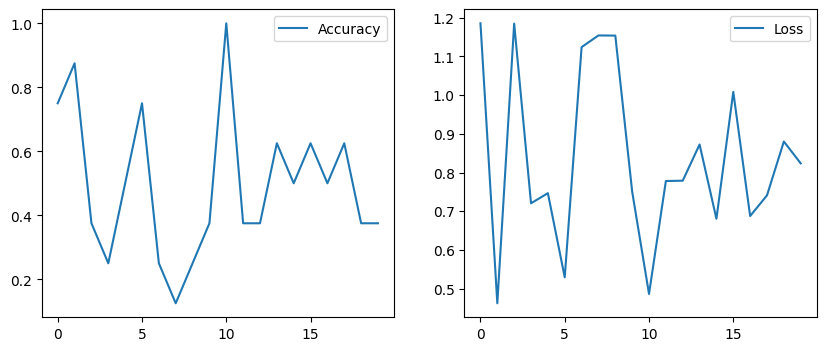

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os


# ✅ Set Dataset Path from Google Drive
DATASET_PATH = "/content/drive/MyDrive/B/dataset"  # Make sure this path is correct

# ✅ Swin Transformer needs 384x384 images
IMG_SIZE = (384, 384)
BATCH_SIZE = 4

# ✅ GPU Check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is being used for training!")
    except RuntimeError as e:
        print(e)

# ✅ Improved Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# ✅ Load a Stronger Pretrained Model (Swin Transformer)
base_model = tf.keras.applications.ConvNeXtLarge(
    input_shape=(384, 384, 3),
    include_top=False,
    weights="imagenet"
)

# ✅ Unfreeze Top 30 Layers for Fine-Tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# ✅ Build the Model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (tight/loose)
])

# ✅ Compile the Model with GPU Optimized Adam
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# ✅ Train the Model
EPOCHS = 20
history = model.fit(train_generator, epochs=EPOCHS)

# ✅ Save Model to Google Drive
model.save("/content/drive/MyDrive/bolt_tightness_model_cuda.h5")

# ✅ Plot Accuracy and Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Loss")
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

# Define a simple dummy version of LayerScale (customize if needed)
class LayerScale(Layer):
    def __init__(self, **kwargs):
        super(LayerScale, self).__init__(**kwargs)
    def call(self, inputs):
        return inputs

# Load the model using custom_objects
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/bolt_tightness_model_cuda.h5",
    custom_objects={"LayerScale": LayerScale}
)

print("Model loaded successfully!")

TypeError: Error when deserializing class 'LayerScale' using config={'name': 'convnext_large_stage_0_block_0_layer_scale', 'trainable': True, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 192}.

Exception encountered: Unrecognized keyword arguments passed to LayerScale: {'init_values': 1e-06, 'projection_dim': 192}

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np

# ✅ Correct LayerScale Implementation for ConvNeXt
class LayerScale(Layer):
    def __init__(self, projection_dim=192, init_values=1e-6, **kwargs):
        super(LayerScale, self).__init__(**kwargs)
        self.projection_dim = projection_dim
        self.init_values = init_values

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),  # Match input channels
            initializer=tf.keras.initializers.Constant(self.init_values),
            trainable=True,
            name="gamma"
        )

    @tf.function
    def call(self, inputs, training=False):  # Handle extra args properly
        return inputs * self.gamma

    def get_config(self):  # Ensure correct deserialization
        config = super().get_config()
        config.update({
            "projection_dim": self.projection_dim,
            "init_values": self.init_values
        })
        return config

# ✅ Load Model with Custom Layer Registered
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/bolt_tightness_model_cuda.h5",
    custom_objects={"LayerScale": LayerScale}
)

print("✅ Model loaded successfully with LayerScale!")

TypeError: too many positional arguments

✅ GPU is being used for training!
Found 8 images belonging to 2 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 61s 115ms/step - accuracy: 0.6667 - loss: 0.6764
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5833 - loss: 0.5928
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7500 - loss: 0.5708
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7500 - loss: 0.3390
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8333 - loss: 0.4003
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.6667 - loss: 0.6002
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 1.0000 - loss: 0.1803
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 1.0000 - loss: 0.1274
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.2019
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.9167 - loss: 0.1448
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 

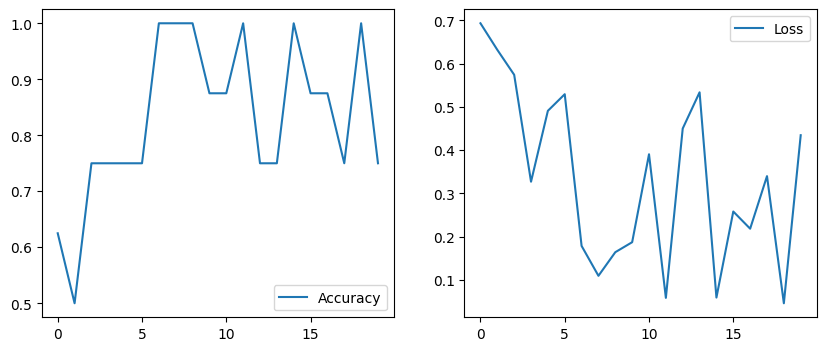

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os



# ✅ Set Dataset Path (Ensure the dataset exists in this path)
DATASET_PATH = "/content/drive/MyDrive/B/dataset/"  # Contains "tight/" and "loose/" subfolders

# ✅ Image Size for ResNet50V2
IMG_SIZE = (224, 224)
BATCH_SIZE = 4

# ✅ Enable GPU (CUDA)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU is being used for training!")
    except RuntimeError as e:
        print(e)

# ✅ Data Augmentation to Improve Model Performance
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# ✅ Load ResNet50V2 Pretrained Model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

# ✅ Unfreeze Top 30 Layers for Fine-Tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# ✅ Build the Final Model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),  # Reduce overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (tight/loose)
])

# ✅ Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# ✅ Train the Model
EPOCHS = 20  # Increase epochs for better accuracy
history = model.fit(train_generator, epochs=EPOCHS)

# ✅ Save the trained model (No Custom Layers)
model.save("/content/drive/MyDrive/bolt_tightness_model_resnet.h5")

# ✅ Plot Training Accuracy and Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Loss")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# ✅ Load Trained Model
model = load_model("/content/drive/MyDrive/bolt_tightness_model_resnet.h5")

# ✅ Function to Predict Bolt Condition
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Match ResNet size
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # ✅ Run Prediction on GPU
    with tf.device('/GPU:0'):
        prediction = model.predict(img_array)[0][0]

    label = "Loose" if prediction > 0.5 else "Tight"
    print(f"Prediction: {label} ({prediction:.2f})")

# ✅ Test on a New Image (Upload to Drive First)
predict_image("/content/drive/MyDrive/B/dataset/tight/20250222_195429.jpg")  # Change path if needed


NameError: name 'tf' is not defined